# Inference for ImageNet dataset using imported models
The predict BYOM function allows you to do inference using models that have not been trained with MADlib, but rather imported from elsewhere. It was added in MADlib 1.17.

In this workbook we load models and trained weights from 
https://keras.io/applications/
and run inference on the ImageNet validation set.

## Table of contents

<a href="#setup">1. Setup</a>

<a href="#load_model">2. Load model architecture and weights</a>

* <a href="#vgg16">2a. VGG16</a>

* <a href="#resnet50">2b. ResNet50</a>

<a href="#load_images">3. Load validation set images</a>

<a href="#predict">4. Inference</a>

* <a href="#vgg16_predict">4a. VGG16</a>

* <a href="#resnet50_predict">4b. ResNet50</a>

<a id="setup"></a>
# 1.  Setup

In [1]:
%load_ext sql

/Users/fmcquillan/anaconda/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/fmcquillan/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
# Greenplum Database 5.x on GCP (PM demo machine) - direct external IP access
#%sql postgresql://gpadmin@34.67.65.96:5432/madlib

# Greenplum Database 5.x on GCP - via tunnel
%sql postgresql://gpadmin@localhost:8000/madlib
        
# PostgreSQL local
#%sql postgresql://fmcquillan@localhost:5432/madlib

u'Connected: gpadmin@madlib'

In [3]:
%sql select madlib.version();
#%sql select version();

1 rows affected.


version
"MADlib version: 1.17-dev, git revision: rel/v1.16-10-g205bdba, cmake configuration time: Mon Aug 26 16:15:40 UTC 2019, build type: release, build system: Linux-3.10.0-957.21.3.el7.x86_64, C compiler: gcc 4.8.5, C++ compiler: g++ 4.8.5"


<a id="load_model"></a>
# 2. Load model architecture and weights

First drop model architecture table

In [19]:
%%sql
DROP TABLE IF EXISTS model_arch_library_imagenet;

Done.


[]

<a id="vgg16"></a>
## 2a. VGG16
Create a PL/Python function to load the model architecture and weights for VGG16

Ref:
Very Deep Convolutional Networks for Large-Scale Image Recognition (Karen Simonyan, Andrew Zisserman)
https://arxiv.org/abs/1409.1556

In [20]:
%%sql
CREATE OR REPLACE FUNCTION load_model_vgg16() RETURNS VOID AS
$$
import keras
from keras.applications.vgg16 import VGG16
import numpy as np
import plpy

# create model
model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

# get weights, flatten and serialize
weights = model.get_weights()
weights_flat = [w.flatten() for w in weights]
weights1d =  np.concatenate(weights_flat).ravel()
weights_bytea = weights1d.tostring()

# load query
load_query = plpy.prepare("""SELECT madlib.load_keras_model(
                        'model_arch_library_imagenet',
                        $1, $2, $3, $4)
                    """, ['json','bytea', 'text', 'text'])
plpy.execute(load_query, [model.to_json(), weights_bytea, "VGG16", "VGG16 model with weights pre-trained on ImageNet."])
$$ language plpythonu;

-- Call load function
SELECT load_model_vgg16();

-- Check weights loaded OK
SELECT model_id, name, description FROM model_arch_library_imagenet;

Done.
1 rows affected.
1 rows affected.


model_id,name,description
1,VGG16,VGG16 model with weights pre-trained on ImageNet.


<a id="resnet50"></a>
## 2b. ResNet50
Create a PL/Python function to load the model architecture and weights for ResNet

Ref:
Deep Residual Learning for Image Recognition (Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun)
https://arxiv.org/abs/1512.03385

In [21]:
%%sql
CREATE OR REPLACE FUNCTION load_model_resnet() RETURNS VOID AS
$$
import keras
from keras.applications.resnet50 import ResNet50
import numpy as np
import plpy

# create model
model = ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

# get weights, flatten and serialize
weights = model.get_weights()
weights_flat = [w.flatten() for w in weights]
weights1d =  np.concatenate(weights_flat).ravel()
weights_bytea = weights1d.tostring()

# load query
load_query = plpy.prepare("""SELECT madlib.load_keras_model(
                        'model_arch_library_imagenet',
                        $1, $2, $3, $4)
                    """, ['json','bytea', 'text', 'text'])
plpy.execute(load_query, [model.to_json(), weights_bytea, "ResNet50", "ResNet50 model with weights pre-trained on ImageNet."])
$$ language plpythonu;

-- Call load function
SELECT load_model_resnet();

-- Check weights loaded OK
SELECT model_id, name, description FROM model_arch_library_imagenet;

Done.
1 rows affected.
2 rows affected.


model_id,name,description
1,VGG16,VGG16 model with weights pre-trained on ImageNet.
2,ResNet50,ResNet50 model with weights pre-trained on ImageNet.


<a id="load_images"></a>
# 3. Load validation set images
Load validation set images (test set image labels not readily available) from http://www.image-net.org/challenges/LSVRC/2012/nonpub-downloads

We use the script called madlib_image_loader.py located at https://github.com/apache/madlib-site/tree/asf-site/community-artifacts/Deep-learning which uses the Python Imaging Library so supports multiple formats http://www.pythonware.com/products/pil/

First initialize loader:

In [4]:
import sys
import os
madlib_site_dir = '/Users/fmcquillan/Documents/Product/MADlib/Demos/data'
sys.path.append(madlib_site_dir)

# Import image loader module
from madlib_image_loader import ImageLoader, DbCredentials

# Specify database credentials, for connecting to db
db_creds = DbCredentials(user='gpadmin',
                         host='localhost',
                         port='8000',
                         password='')

# Specify database credentials, for connecting to db
#db_creds = DbCredentials(user='fmcquillan',
#                          host='localhost',
#                          port='5432',
#                          password='')

# Initialize ImageLoader (increase num_workers to run faster)
iloader = ImageLoader(num_workers=8, db_creds=db_creds)

Load the validation dataset images in chunks for memory reasons.  Labels are in a separate file that must be mapped from Caffe format:

In [5]:
from scipy.io import loadmat
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input # Only import the model-specific preprocessing function
import glob
import os
import numpy as np

CAFFE_LABELS = {"0": ["n01440764", "tench"], "1": ["n01443537", "goldfish"], "2": ["n01484850", "great_white_shark"], "3": ["n01491361", "tiger_shark"], "4": ["n01494475", "hammerhead"], "5": ["n01496331", "electric_ray"], "6": ["n01498041", "stingray"], "7": ["n01514668", "cock"], "8": ["n01514859", "hen"], "9": ["n01518878", "ostrich"], "10": ["n01530575", "brambling"], "11": ["n01531178", "goldfinch"], "12": ["n01532829", "house_finch"], "13": ["n01534433", "junco"], "14": ["n01537544", "indigo_bunting"], "15": ["n01558993", "robin"], "16": ["n01560419", "bulbul"], "17": ["n01580077", "jay"], "18": ["n01582220", "magpie"], "19": ["n01592084", "chickadee"], "20": ["n01601694", "water_ouzel"], "21": ["n01608432", "kite"], "22": ["n01614925", "bald_eagle"], "23": ["n01616318", "vulture"], "24": ["n01622779", "great_grey_owl"], "25": ["n01629819", "European_fire_salamander"], "26": ["n01630670", "common_newt"], "27": ["n01631663", "eft"], "28": ["n01632458", "spotted_salamander"], "29": ["n01632777", "axolotl"], "30": ["n01641577", "bullfrog"], "31": ["n01644373", "tree_frog"], "32": ["n01644900", "tailed_frog"], "33": ["n01664065", "loggerhead"], "34": ["n01665541", "leatherback_turtle"], "35": ["n01667114", "mud_turtle"], "36": ["n01667778", "terrapin"], "37": ["n01669191", "box_turtle"], "38": ["n01675722", "banded_gecko"], "39": ["n01677366", "common_iguana"], "40": ["n01682714", "American_chameleon"], "41": ["n01685808", "whiptail"], "42": ["n01687978", "agama"], "43": ["n01688243", "frilled_lizard"], "44": ["n01689811", "alligator_lizard"], "45": ["n01692333", "Gila_monster"], "46": ["n01693334", "green_lizard"], "47": ["n01694178", "African_chameleon"], "48": ["n01695060", "Komodo_dragon"], "49": ["n01697457", "African_crocodile"], "50": ["n01698640", "American_alligator"], "51": ["n01704323", "triceratops"], "52": ["n01728572", "thunder_snake"], "53": ["n01728920", "ringneck_snake"], "54": ["n01729322", "hognose_snake"], "55": ["n01729977", "green_snake"], "56": ["n01734418", "king_snake"], "57": ["n01735189", "garter_snake"], "58": ["n01737021", "water_snake"], "59": ["n01739381", "vine_snake"], "60": ["n01740131", "night_snake"], "61": ["n01742172", "boa_constrictor"], "62": ["n01744401", "rock_python"], "63": ["n01748264", "Indian_cobra"], "64": ["n01749939", "green_mamba"], "65": ["n01751748", "sea_snake"], "66": ["n01753488", "horned_viper"], "67": ["n01755581", "diamondback"], "68": ["n01756291", "sidewinder"], "69": ["n01768244", "trilobite"], "70": ["n01770081", "harvestman"], "71": ["n01770393", "scorpion"], "72": ["n01773157", "black_and_gold_garden_spider"], "73": ["n01773549", "barn_spider"], "74": ["n01773797", "garden_spider"], "75": ["n01774384", "black_widow"], "76": ["n01774750", "tarantula"], "77": ["n01775062", "wolf_spider"], "78": ["n01776313", "tick"], "79": ["n01784675", "centipede"], "80": ["n01795545", "black_grouse"], "81": ["n01796340", "ptarmigan"], "82": ["n01797886", "ruffed_grouse"], "83": ["n01798484", "prairie_chicken"], "84": ["n01806143", "peacock"], "85": ["n01806567", "quail"], "86": ["n01807496", "partridge"], "87": ["n01817953", "African_grey"], "88": ["n01818515", "macaw"], "89": ["n01819313", "sulphur-crested_cockatoo"], "90": ["n01820546", "lorikeet"], "91": ["n01824575", "coucal"], "92": ["n01828970", "bee_eater"], "93": ["n01829413", "hornbill"], "94": ["n01833805", "hummingbird"], "95": ["n01843065", "jacamar"], "96": ["n01843383", "toucan"], "97": ["n01847000", "drake"], "98": ["n01855032", "red-breasted_merganser"], "99": ["n01855672", "goose"], "100": ["n01860187", "black_swan"], "101": ["n01871265", "tusker"], "102": ["n01872401", "echidna"], "103": ["n01873310", "platypus"], "104": ["n01877812", "wallaby"], "105": ["n01882714", "koala"], "106": ["n01883070", "wombat"], "107": ["n01910747", "jellyfish"], "108": ["n01914609", "sea_anemone"], "109": ["n01917289", "brain_coral"], "110": ["n01924916", "flatworm"], "111": ["n01930112", "nematode"], "112": ["n01943899", "conch"], "113": ["n01944390", "snail"], "114": ["n01945685", "slug"], "115": ["n01950731", "sea_slug"], "116": ["n01955084", "chiton"], "117": ["n01968897", "chambered_nautilus"], "118": ["n01978287", "Dungeness_crab"], "119": ["n01978455", "rock_crab"], "120": ["n01980166", "fiddler_crab"], "121": ["n01981276", "king_crab"], "122": ["n01983481", "American_lobster"], "123": ["n01984695", "spiny_lobster"], "124": ["n01985128", "crayfish"], "125": ["n01986214", "hermit_crab"], "126": ["n01990800", "isopod"], "127": ["n02002556", "white_stork"], "128": ["n02002724", "black_stork"], "129": ["n02006656", "spoonbill"], "130": ["n02007558", "flamingo"], "131": ["n02009229", "little_blue_heron"], "132": ["n02009912", "American_egret"], "133": ["n02011460", "bittern"], "134": ["n02012849", "crane"], "135": ["n02013706", "limpkin"], "136": ["n02017213", "European_gallinule"], "137": ["n02018207", "American_coot"], "138": ["n02018795", "bustard"], "139": ["n02025239", "ruddy_turnstone"], "140": ["n02027492", "red-backed_sandpiper"], "141": ["n02028035", "redshank"], "142": ["n02033041", "dowitcher"], "143": ["n02037110", "oystercatcher"], "144": ["n02051845", "pelican"], "145": ["n02056570", "king_penguin"], "146": ["n02058221", "albatross"], "147": ["n02066245", "grey_whale"], "148": ["n02071294", "killer_whale"], "149": ["n02074367", "dugong"], "150": ["n02077923", "sea_lion"], "151": ["n02085620", "Chihuahua"], "152": ["n02085782", "Japanese_spaniel"], "153": ["n02085936", "Maltese_dog"], "154": ["n02086079", "Pekinese"], "155": ["n02086240", "Shih-Tzu"], "156": ["n02086646", "Blenheim_spaniel"], "157": ["n02086910", "papillon"], "158": ["n02087046", "toy_terrier"], "159": ["n02087394", "Rhodesian_ridgeback"], "160": ["n02088094", "Afghan_hound"], "161": ["n02088238", "basset"], "162": ["n02088364", "beagle"], "163": ["n02088466", "bloodhound"], "164": ["n02088632", "bluetick"], "165": ["n02089078", "black-and-tan_coonhound"], "166": ["n02089867", "Walker_hound"], "167": ["n02089973", "English_foxhound"], "168": ["n02090379", "redbone"], "169": ["n02090622", "borzoi"], "170": ["n02090721", "Irish_wolfhound"], "171": ["n02091032", "Italian_greyhound"], "172": ["n02091134", "whippet"], "173": ["n02091244", "Ibizan_hound"], "174": ["n02091467", "Norwegian_elkhound"], "175": ["n02091635", "otterhound"], "176": ["n02091831", "Saluki"], "177": ["n02092002", "Scottish_deerhound"], "178": ["n02092339", "Weimaraner"], "179": ["n02093256", "Staffordshire_bullterrier"], "180": ["n02093428", "American_Staffordshire_terrier"], "181": ["n02093647", "Bedlington_terrier"], "182": ["n02093754", "Border_terrier"], "183": ["n02093859", "Kerry_blue_terrier"], "184": ["n02093991", "Irish_terrier"], "185": ["n02094114", "Norfolk_terrier"], "186": ["n02094258", "Norwich_terrier"], "187": ["n02094433", "Yorkshire_terrier"], "188": ["n02095314", "wire-haired_fox_terrier"], "189": ["n02095570", "Lakeland_terrier"], "190": ["n02095889", "Sealyham_terrier"], "191": ["n02096051", "Airedale"], "192": ["n02096177", "cairn"], "193": ["n02096294", "Australian_terrier"], "194": ["n02096437", "Dandie_Dinmont"], "195": ["n02096585", "Boston_bull"], "196": ["n02097047", "miniature_schnauzer"], "197": ["n02097130", "giant_schnauzer"], "198": ["n02097209", "standard_schnauzer"], "199": ["n02097298", "Scotch_terrier"], "200": ["n02097474", "Tibetan_terrier"], "201": ["n02097658", "silky_terrier"], "202": ["n02098105", "soft-coated_wheaten_terrier"], "203": ["n02098286", "West_Highland_white_terrier"], "204": ["n02098413", "Lhasa"], "205": ["n02099267", "flat-coated_retriever"], "206": ["n02099429", "curly-coated_retriever"], "207": ["n02099601", "golden_retriever"], "208": ["n02099712", "Labrador_retriever"], "209": ["n02099849", "Chesapeake_Bay_retriever"], "210": ["n02100236", "German_short-haired_pointer"], "211": ["n02100583", "vizsla"], "212": ["n02100735", "English_setter"], "213": ["n02100877", "Irish_setter"], "214": ["n02101006", "Gordon_setter"], "215": ["n02101388", "Brittany_spaniel"], "216": ["n02101556", "clumber"], "217": ["n02102040", "English_springer"], "218": ["n02102177", "Welsh_springer_spaniel"], "219": ["n02102318", "cocker_spaniel"], "220": ["n02102480", "Sussex_spaniel"], "221": ["n02102973", "Irish_water_spaniel"], "222": ["n02104029", "kuvasz"], "223": ["n02104365", "schipperke"], "224": ["n02105056", "groenendael"], "225": ["n02105162", "malinois"], "226": ["n02105251", "briard"], "227": ["n02105412", "kelpie"], "228": ["n02105505", "komondor"], "229": ["n02105641", "Old_English_sheepdog"], "230": ["n02105855", "Shetland_sheepdog"], "231": ["n02106030", "collie"], "232": ["n02106166", "Border_collie"], "233": ["n02106382", "Bouvier_des_Flandres"], "234": ["n02106550", "Rottweiler"], "235": ["n02106662", "German_shepherd"], "236": ["n02107142", "Doberman"], "237": ["n02107312", "miniature_pinscher"], "238": ["n02107574", "Greater_Swiss_Mountain_dog"], "239": ["n02107683", "Bernese_mountain_dog"], "240": ["n02107908", "Appenzeller"], "241": ["n02108000", "EntleBucher"], "242": ["n02108089", "boxer"], "243": ["n02108422", "bull_mastiff"], "244": ["n02108551", "Tibetan_mastiff"], "245": ["n02108915", "French_bulldog"], "246": ["n02109047", "Great_Dane"], "247": ["n02109525", "Saint_Bernard"], "248": ["n02109961", "Eskimo_dog"], "249": ["n02110063", "malamute"], "250": ["n02110185", "Siberian_husky"], "251": ["n02110341", "dalmatian"], "252": ["n02110627", "affenpinscher"], "253": ["n02110806", "basenji"], "254": ["n02110958", "pug"], "255": ["n02111129", "Leonberg"], "256": ["n02111277", "Newfoundland"], "257": ["n02111500", "Great_Pyrenees"], "258": ["n02111889", "Samoyed"], "259": ["n02112018", "Pomeranian"], "260": ["n02112137", "chow"], "261": ["n02112350", "keeshond"], "262": ["n02112706", "Brabancon_griffon"], "263": ["n02113023", "Pembroke"], "264": ["n02113186", "Cardigan"], "265": ["n02113624", "toy_poodle"], "266": ["n02113712", "miniature_poodle"], "267": ["n02113799", "standard_poodle"], "268": ["n02113978", "Mexican_hairless"], "269": ["n02114367", "timber_wolf"], "270": ["n02114548", "white_wolf"], "271": ["n02114712", "red_wolf"], "272": ["n02114855", "coyote"], "273": ["n02115641", "dingo"], "274": ["n02115913", "dhole"], "275": ["n02116738", "African_hunting_dog"], "276": ["n02117135", "hyena"], "277": ["n02119022", "red_fox"], "278": ["n02119789", "kit_fox"], "279": ["n02120079", "Arctic_fox"], "280": ["n02120505", "grey_fox"], "281": ["n02123045", "tabby"], "282": ["n02123159", "tiger_cat"], "283": ["n02123394", "Persian_cat"], "284": ["n02123597", "Siamese_cat"], "285": ["n02124075", "Egyptian_cat"], "286": ["n02125311", "cougar"], "287": ["n02127052", "lynx"], "288": ["n02128385", "leopard"], "289": ["n02128757", "snow_leopard"], "290": ["n02128925", "jaguar"], "291": ["n02129165", "lion"], "292": ["n02129604", "tiger"], "293": ["n02130308", "cheetah"], "294": ["n02132136", "brown_bear"], "295": ["n02133161", "American_black_bear"], "296": ["n02134084", "ice_bear"], "297": ["n02134418", "sloth_bear"], "298": ["n02137549", "mongoose"], "299": ["n02138441", "meerkat"], "300": ["n02165105", "tiger_beetle"], "301": ["n02165456", "ladybug"], "302": ["n02167151", "ground_beetle"], "303": ["n02168699", "long-horned_beetle"], "304": ["n02169497", "leaf_beetle"], "305": ["n02172182", "dung_beetle"], "306": ["n02174001", "rhinoceros_beetle"], "307": ["n02177972", "weevil"], "308": ["n02190166", "fly"], "309": ["n02206856", "bee"], "310": ["n02219486", "ant"], "311": ["n02226429", "grasshopper"], "312": ["n02229544", "cricket"], "313": ["n02231487", "walking_stick"], "314": ["n02233338", "cockroach"], "315": ["n02236044", "mantis"], "316": ["n02256656", "cicada"], "317": ["n02259212", "leafhopper"], "318": ["n02264363", "lacewing"], "319": ["n02268443", "dragonfly"], "320": ["n02268853", "damselfly"], "321": ["n02276258", "admiral"], "322": ["n02277742", "ringlet"], "323": ["n02279972", "monarch"], "324": ["n02280649", "cabbage_butterfly"], "325": ["n02281406", "sulphur_butterfly"], "326": ["n02281787", "lycaenid"], "327": ["n02317335", "starfish"], "328": ["n02319095", "sea_urchin"], "329": ["n02321529", "sea_cucumber"], "330": ["n02325366", "wood_rabbit"], "331": ["n02326432", "hare"], "332": ["n02328150", "Angora"], "333": ["n02342885", "hamster"], "334": ["n02346627", "porcupine"], "335": ["n02356798", "fox_squirrel"], "336": ["n02361337", "marmot"], "337": ["n02363005", "beaver"], "338": ["n02364673", "guinea_pig"], "339": ["n02389026", "sorrel"], "340": ["n02391049", "zebra"], "341": ["n02395406", "hog"], "342": ["n02396427", "wild_boar"], "343": ["n02397096", "warthog"], "344": ["n02398521", "hippopotamus"], "345": ["n02403003", "ox"], "346": ["n02408429", "water_buffalo"], "347": ["n02410509", "bison"], "348": ["n02412080", "ram"], "349": ["n02415577", "bighorn"], "350": ["n02417914", "ibex"], "351": ["n02422106", "hartebeest"], "352": ["n02422699", "impala"], "353": ["n02423022", "gazelle"], "354": ["n02437312", "Arabian_camel"], "355": ["n02437616", "llama"], "356": ["n02441942", "weasel"], "357": ["n02442845", "mink"], "358": ["n02443114", "polecat"], "359": ["n02443484", "black-footed_ferret"], "360": ["n02444819", "otter"], "361": ["n02445715", "skunk"], "362": ["n02447366", "badger"], "363": ["n02454379", "armadillo"], "364": ["n02457408", "three-toed_sloth"], "365": ["n02480495", "orangutan"], "366": ["n02480855", "gorilla"], "367": ["n02481823", "chimpanzee"], "368": ["n02483362", "gibbon"], "369": ["n02483708", "siamang"], "370": ["n02484975", "guenon"], "371": ["n02486261", "patas"], "372": ["n02486410", "baboon"], "373": ["n02487347", "macaque"], "374": ["n02488291", "langur"], "375": ["n02488702", "colobus"], "376": ["n02489166", "proboscis_monkey"], "377": ["n02490219", "marmoset"], "378": ["n02492035", "capuchin"], "379": ["n02492660", "howler_monkey"], "380": ["n02493509", "titi"], "381": ["n02493793", "spider_monkey"], "382": ["n02494079", "squirrel_monkey"], "383": ["n02497673", "Madagascar_cat"], "384": ["n02500267", "indri"], "385": ["n02504013", "Indian_elephant"], "386": ["n02504458", "African_elephant"], "387": ["n02509815", "lesser_panda"], "388": ["n02510455", "giant_panda"], "389": ["n02514041", "barracouta"], "390": ["n02526121", "eel"], "391": ["n02536864", "coho"], "392": ["n02606052", "rock_beauty"], "393": ["n02607072", "anemone_fish"], "394": ["n02640242", "sturgeon"], "395": ["n02641379", "gar"], "396": ["n02643566", "lionfish"], "397": ["n02655020", "puffer"], "398": ["n02666196", "abacus"], "399": ["n02667093", "abaya"], "400": ["n02669723", "academic_gown"], "401": ["n02672831", "accordion"], "402": ["n02676566", "acoustic_guitar"], "403": ["n02687172", "aircraft_carrier"], "404": ["n02690373", "airliner"], "405": ["n02692877", "airship"], "406": ["n02699494", "altar"], "407": ["n02701002", "ambulance"], "408": ["n02704792", "amphibian"], "409": ["n02708093", "analog_clock"], "410": ["n02727426", "apiary"], "411": ["n02730930", "apron"], "412": ["n02747177", "ashcan"], "413": ["n02749479", "assault_rifle"], "414": ["n02769748", "backpack"], "415": ["n02776631", "bakery"], "416": ["n02777292", "balance_beam"], "417": ["n02782093", "balloon"], "418": ["n02783161", "ballpoint"], "419": ["n02786058", "Band_Aid"], "420": ["n02787622", "banjo"], "421": ["n02788148", "bannister"], "422": ["n02790996", "barbell"], "423": ["n02791124", "barber_chair"], "424": ["n02791270", "barbershop"], "425": ["n02793495", "barn"], "426": ["n02794156", "barometer"], "427": ["n02795169", "barrel"], "428": ["n02797295", "barrow"], "429": ["n02799071", "baseball"], "430": ["n02802426", "basketball"], "431": ["n02804414", "bassinet"], "432": ["n02804610", "bassoon"], "433": ["n02807133", "bathing_cap"], "434": ["n02808304", "bath_towel"], "435": ["n02808440", "bathtub"], "436": ["n02814533", "beach_wagon"], "437": ["n02814860", "beacon"], "438": ["n02815834", "beaker"], "439": ["n02817516", "bearskin"], "440": ["n02823428", "beer_bottle"], "441": ["n02823750", "beer_glass"], "442": ["n02825657", "bell_cote"], "443": ["n02834397", "bib"], "444": ["n02835271", "bicycle-built-for-two"], "445": ["n02837789", "bikini"], "446": ["n02840245", "binder"], "447": ["n02841315", "binoculars"], "448": ["n02843684", "birdhouse"], "449": ["n02859443", "boathouse"], "450": ["n02860847", "bobsled"], "451": ["n02865351", "bolo_tie"], "452": ["n02869837", "bonnet"], "453": ["n02870880", "bookcase"], "454": ["n02871525", "bookshop"], "455": ["n02877765", "bottlecap"], "456": ["n02879718", "bow"], "457": ["n02883205", "bow_tie"], "458": ["n02892201", "brass"], "459": ["n02892767", "brassiere"], "460": ["n02894605", "breakwater"], "461": ["n02895154", "breastplate"], "462": ["n02906734", "broom"], "463": ["n02909870", "bucket"], "464": ["n02910353", "buckle"], "465": ["n02916936", "bulletproof_vest"], "466": ["n02917067", "bullet_train"], "467": ["n02927161", "butcher_shop"], "468": ["n02930766", "cab"], "469": ["n02939185", "caldron"], "470": ["n02948072", "candle"], "471": ["n02950826", "cannon"], "472": ["n02951358", "canoe"], "473": ["n02951585", "can_opener"], "474": ["n02963159", "cardigan"], "475": ["n02965783", "car_mirror"], "476": ["n02966193", "carousel"], "477": ["n02966687", "carpenter's_kit"], "478": ["n02971356", "carton"], "479": ["n02974003", "car_wheel"], "480": ["n02977058", "cash_machine"], "481": ["n02978881", "cassette"], "482": ["n02979186", "cassette_player"], "483": ["n02980441", "castle"], "484": ["n02981792", "catamaran"], "485": ["n02988304", "CD_player"], "486": ["n02992211", "cello"], "487": ["n02992529", "cellular_telephone"], "488": ["n02999410", "chain"], "489": ["n03000134", "chainlink_fence"], "490": ["n03000247", "chain_mail"], "491": ["n03000684", "chain_saw"], "492": ["n03014705", "chest"], "493": ["n03016953", "chiffonier"], "494": ["n03017168", "chime"], "495": ["n03018349", "china_cabinet"], "496": ["n03026506", "Christmas_stocking"], "497": ["n03028079", "church"], "498": ["n03032252", "cinema"], "499": ["n03041632", "cleaver"], "500": ["n03042490", "cliff_dwelling"], "501": ["n03045698", "cloak"], "502": ["n03047690", "clog"], "503": ["n03062245", "cocktail_shaker"], "504": ["n03063599", "coffee_mug"], "505": ["n03063689", "coffeepot"], "506": ["n03065424", "coil"], "507": ["n03075370", "combination_lock"], "508": ["n03085013", "computer_keyboard"], "509": ["n03089624", "confectionery"], "510": ["n03095699", "container_ship"], "511": ["n03100240", "convertible"], "512": ["n03109150", "corkscrew"], "513": ["n03110669", "cornet"], "514": ["n03124043", "cowboy_boot"], "515": ["n03124170", "cowboy_hat"], "516": ["n03125729", "cradle"], "517": ["n03126707", "crane"], "518": ["n03127747", "crash_helmet"], "519": ["n03127925", "crate"], "520": ["n03131574", "crib"], "521": ["n03133878", "Crock_Pot"], "522": ["n03134739", "croquet_ball"], "523": ["n03141823", "crutch"], "524": ["n03146219", "cuirass"], "525": ["n03160309", "dam"], "526": ["n03179701", "desk"], "527": ["n03180011", "desktop_computer"], "528": ["n03187595", "dial_telephone"], "529": ["n03188531", "diaper"], "530": ["n03196217", "digital_clock"], "531": ["n03197337", "digital_watch"], "532": ["n03201208", "dining_table"], "533": ["n03207743", "dishrag"], "534": ["n03207941", "dishwasher"], "535": ["n03208938", "disk_brake"], "536": ["n03216828", "dock"], "537": ["n03218198", "dogsled"], "538": ["n03220513", "dome"], "539": ["n03223299", "doormat"], "540": ["n03240683", "drilling_platform"], "541": ["n03249569", "drum"], "542": ["n03250847", "drumstick"], "543": ["n03255030", "dumbbell"], "544": ["n03259280", "Dutch_oven"], "545": ["n03271574", "electric_fan"], "546": ["n03272010", "electric_guitar"], "547": ["n03272562", "electric_locomotive"], "548": ["n03290653", "entertainment_center"], "549": ["n03291819", "envelope"], "550": ["n03297495", "espresso_maker"], "551": ["n03314780", "face_powder"], "552": ["n03325584", "feather_boa"], "553": ["n03337140", "file"], "554": ["n03344393", "fireboat"], "555": ["n03345487", "fire_engine"], "556": ["n03347037", "fire_screen"], "557": ["n03355925", "flagpole"], "558": ["n03372029", "flute"], "559": ["n03376595", "folding_chair"], "560": ["n03379051", "football_helmet"], "561": ["n03384352", "forklift"], "562": ["n03388043", "fountain"], "563": ["n03388183", "fountain_pen"], "564": ["n03388549", "four-poster"], "565": ["n03393912", "freight_car"], "566": ["n03394916", "French_horn"], "567": ["n03400231", "frying_pan"], "568": ["n03404251", "fur_coat"], "569": ["n03417042", "garbage_truck"], "570": ["n03424325", "gasmask"], "571": ["n03425413", "gas_pump"], "572": ["n03443371", "goblet"], "573": ["n03444034", "go-kart"], "574": ["n03445777", "golf_ball"], "575": ["n03445924", "golfcart"], "576": ["n03447447", "gondola"], "577": ["n03447721", "gong"], "578": ["n03450230", "gown"], "579": ["n03452741", "grand_piano"], "580": ["n03457902", "greenhouse"], "581": ["n03459775", "grille"], "582": ["n03461385", "grocery_store"], "583": ["n03467068", "guillotine"], "584": ["n03476684", "hair_slide"], "585": ["n03476991", "hair_spray"], "586": ["n03478589", "half_track"], "587": ["n03481172", "hammer"], "588": ["n03482405", "hamper"], "589": ["n03483316", "hand_blower"], "590": ["n03485407", "hand-held_computer"], "591": ["n03485794", "handkerchief"], "592": ["n03492542", "hard_disc"], "593": ["n03494278", "harmonica"], "594": ["n03495258", "harp"], "595": ["n03496892", "harvester"], "596": ["n03498962", "hatchet"], "597": ["n03527444", "holster"], "598": ["n03529860", "home_theater"], "599": ["n03530642", "honeycomb"], "600": ["n03532672", "hook"], "601": ["n03534580", "hoopskirt"], "602": ["n03535780", "horizontal_bar"], "603": ["n03538406", "horse_cart"], "604": ["n03544143", "hourglass"], "605": ["n03584254", "iPod"], "606": ["n03584829", "iron"], "607": ["n03590841", "jack-o'-lantern"], "608": ["n03594734", "jean"], "609": ["n03594945", "jeep"], "610": ["n03595614", "jersey"], "611": ["n03598930", "jigsaw_puzzle"], "612": ["n03599486", "jinrikisha"], "613": ["n03602883", "joystick"], "614": ["n03617480", "kimono"], "615": ["n03623198", "knee_pad"], "616": ["n03627232", "knot"], "617": ["n03630383", "lab_coat"], "618": ["n03633091", "ladle"], "619": ["n03637318", "lampshade"], "620": ["n03642806", "laptop"], "621": ["n03649909", "lawn_mower"], "622": ["n03657121", "lens_cap"], "623": ["n03658185", "letter_opener"], "624": ["n03661043", "library"], "625": ["n03662601", "lifeboat"], "626": ["n03666591", "lighter"], "627": ["n03670208", "limousine"], "628": ["n03673027", "liner"], "629": ["n03676483", "lipstick"], "630": ["n03680355", "Loafer"], "631": ["n03690938", "lotion"], "632": ["n03691459", "loudspeaker"], "633": ["n03692522", "loupe"], "634": ["n03697007", "lumbermill"], "635": ["n03706229", "magnetic_compass"], "636": ["n03709823", "mailbag"], "637": ["n03710193", "mailbox"], "638": ["n03710637", "maillot"], "639": ["n03710721", "maillot"], "640": ["n03717622", "manhole_cover"], "641": ["n03720891", "maraca"], "642": ["n03721384", "marimba"], "643": ["n03724870", "mask"], "644": ["n03729826", "matchstick"], "645": ["n03733131", "maypole"], "646": ["n03733281", "maze"], "647": ["n03733805", "measuring_cup"], "648": ["n03742115", "medicine_chest"], "649": ["n03743016", "megalith"], "650": ["n03759954", "microphone"], "651": ["n03761084", "microwave"], "652": ["n03763968", "military_uniform"], "653": ["n03764736", "milk_can"], "654": ["n03769881", "minibus"], "655": ["n03770439", "miniskirt"], "656": ["n03770679", "minivan"], "657": ["n03773504", "missile"], "658": ["n03775071", "mitten"], "659": ["n03775546", "mixing_bowl"], "660": ["n03776460", "mobile_home"], "661": ["n03777568", "Model_T"], "662": ["n03777754", "modem"], "663": ["n03781244", "monastery"], "664": ["n03782006", "monitor"], "665": ["n03785016", "moped"], "666": ["n03786901", "mortar"], "667": ["n03787032", "mortarboard"], "668": ["n03788195", "mosque"], "669": ["n03788365", "mosquito_net"], "670": ["n03791053", "motor_scooter"], "671": ["n03792782", "mountain_bike"], "672": ["n03792972", "mountain_tent"], "673": ["n03793489", "mouse"], "674": ["n03794056", "mousetrap"], "675": ["n03796401", "moving_van"], "676": ["n03803284", "muzzle"], "677": ["n03804744", "nail"], "678": ["n03814639", "neck_brace"], "679": ["n03814906", "necklace"], "680": ["n03825788", "nipple"], "681": ["n03832673", "notebook"], "682": ["n03837869", "obelisk"], "683": ["n03838899", "oboe"], "684": ["n03840681", "ocarina"], "685": ["n03841143", "odometer"], "686": ["n03843555", "oil_filter"], "687": ["n03854065", "organ"], "688": ["n03857828", "oscilloscope"], "689": ["n03866082", "overskirt"], "690": ["n03868242", "oxcart"], "691": ["n03868863", "oxygen_mask"], "692": ["n03871628", "packet"], "693": ["n03873416", "paddle"], "694": ["n03874293", "paddlewheel"], "695": ["n03874599", "padlock"], "696": ["n03876231", "paintbrush"], "697": ["n03877472", "pajama"], "698": ["n03877845", "palace"], "699": ["n03884397", "panpipe"], "700": ["n03887697", "paper_towel"], "701": ["n03888257", "parachute"], "702": ["n03888605", "parallel_bars"], "703": ["n03891251", "park_bench"], "704": ["n03891332", "parking_meter"], "705": ["n03895866", "passenger_car"], "706": ["n03899768", "patio"], "707": ["n03902125", "pay-phone"], "708": ["n03903868", "pedestal"], "709": ["n03908618", "pencil_box"], "710": ["n03908714", "pencil_sharpener"], "711": ["n03916031", "perfume"], "712": ["n03920288", "Petri_dish"], "713": ["n03924679", "photocopier"], "714": ["n03929660", "pick"], "715": ["n03929855", "pickelhaube"], "716": ["n03930313", "picket_fence"], "717": ["n03930630", "pickup"], "718": ["n03933933", "pier"], "719": ["n03935335", "piggy_bank"], "720": ["n03937543", "pill_bottle"], "721": ["n03938244", "pillow"], "722": ["n03942813", "ping-pong_ball"], "723": ["n03944341", "pinwheel"], "724": ["n03947888", "pirate"], "725": ["n03950228", "pitcher"], "726": ["n03954731", "plane"], "727": ["n03956157", "planetarium"], "728": ["n03958227", "plastic_bag"], "729": ["n03961711", "plate_rack"], "730": ["n03967562", "plow"], "731": ["n03970156", "plunger"], "732": ["n03976467", "Polaroid_camera"], "733": ["n03976657", "pole"], "734": ["n03977966", "police_van"], "735": ["n03980874", "poncho"], "736": ["n03982430", "pool_table"], "737": ["n03983396", "pop_bottle"], "738": ["n03991062", "pot"], "739": ["n03992509", "potter's_wheel"], "740": ["n03995372", "power_drill"], "741": ["n03998194", "prayer_rug"], "742": ["n04004767", "printer"], "743": ["n04005630", "prison"], "744": ["n04008634", "projectile"], "745": ["n04009552", "projector"], "746": ["n04019541", "puck"], "747": ["n04023962", "punching_bag"], "748": ["n04026417", "purse"], "749": ["n04033901", "quill"], "750": ["n04033995", "quilt"], "751": ["n04037443", "racer"], "752": ["n04039381", "racket"], "753": ["n04040759", "radiator"], "754": ["n04041544", "radio"], "755": ["n04044716", "radio_telescope"], "756": ["n04049303", "rain_barrel"], "757": ["n04065272", "recreational_vehicle"], "758": ["n04067472", "reel"], "759": ["n04069434", "reflex_camera"], "760": ["n04070727", "refrigerator"], "761": ["n04074963", "remote_control"], "762": ["n04081281", "restaurant"], "763": ["n04086273", "revolver"], "764": ["n04090263", "rifle"], "765": ["n04099969", "rocking_chair"], "766": ["n04111531", "rotisserie"], "767": ["n04116512", "rubber_eraser"], "768": ["n04118538", "rugby_ball"], "769": ["n04118776", "rule"], "770": ["n04120489", "running_shoe"], "771": ["n04125021", "safe"], "772": ["n04127249", "safety_pin"], "773": ["n04131690", "saltshaker"], "774": ["n04133789", "sandal"], "775": ["n04136333", "sarong"], "776": ["n04141076", "sax"], "777": ["n04141327", "scabbard"], "778": ["n04141975", "scale"], "779": ["n04146614", "school_bus"], "780": ["n04147183", "schooner"], "781": ["n04149813", "scoreboard"], "782": ["n04152593", "screen"], "783": ["n04153751", "screw"], "784": ["n04154565", "screwdriver"], "785": ["n04162706", "seat_belt"], "786": ["n04179913", "sewing_machine"], "787": ["n04192698", "shield"], "788": ["n04200800", "shoe_shop"], "789": ["n04201297", "shoji"], "790": ["n04204238", "shopping_basket"], "791": ["n04204347", "shopping_cart"], "792": ["n04208210", "shovel"], "793": ["n04209133", "shower_cap"], "794": ["n04209239", "shower_curtain"], "795": ["n04228054", "ski"], "796": ["n04229816", "ski_mask"], "797": ["n04235860", "sleeping_bag"], "798": ["n04238763", "slide_rule"], "799": ["n04239074", "sliding_door"], "800": ["n04243546", "slot"], "801": ["n04251144", "snorkel"], "802": ["n04252077", "snowmobile"], "803": ["n04252225", "snowplow"], "804": ["n04254120", "soap_dispenser"], "805": ["n04254680", "soccer_ball"], "806": ["n04254777", "sock"], "807": ["n04258138", "solar_dish"], "808": ["n04259630", "sombrero"], "809": ["n04263257", "soup_bowl"], "810": ["n04264628", "space_bar"], "811": ["n04265275", "space_heater"], "812": ["n04266014", "space_shuttle"], "813": ["n04270147", "spatula"], "814": ["n04273569", "speedboat"], "815": ["n04275548", "spider_web"], "816": ["n04277352", "spindle"], "817": ["n04285008", "sports_car"], "818": ["n04286575", "spotlight"], "819": ["n04296562", "stage"], "820": ["n04310018", "steam_locomotive"], "821": ["n04311004", "steel_arch_bridge"], "822": ["n04311174", "steel_drum"], "823": ["n04317175", "stethoscope"], "824": ["n04325704", "stole"], "825": ["n04326547", "stone_wall"], "826": ["n04328186", "stopwatch"], "827": ["n04330267", "stove"], "828": ["n04332243", "strainer"], "829": ["n04335435", "streetcar"], "830": ["n04336792", "stretcher"], "831": ["n04344873", "studio_couch"], "832": ["n04346328", "stupa"], "833": ["n04347754", "submarine"], "834": ["n04350905", "suit"], "835": ["n04355338", "sundial"], "836": ["n04355933", "sunglass"], "837": ["n04356056", "sunglasses"], "838": ["n04357314", "sunscreen"], "839": ["n04366367", "suspension_bridge"], "840": ["n04367480", "swab"], "841": ["n04370456", "sweatshirt"], "842": ["n04371430", "swimming_trunks"], "843": ["n04371774", "swing"], "844": ["n04372370", "switch"], "845": ["n04376876", "syringe"], "846": ["n04380533", "table_lamp"], "847": ["n04389033", "tank"], "848": ["n04392985", "tape_player"], "849": ["n04398044", "teapot"], "850": ["n04399382", "teddy"], "851": ["n04404412", "television"], "852": ["n04409515", "tennis_ball"], "853": ["n04417672", "thatch"], "854": ["n04418357", "theater_curtain"], "855": ["n04423845", "thimble"], "856": ["n04428191", "thresher"], "857": ["n04429376", "throne"], "858": ["n04435653", "tile_roof"], "859": ["n04442312", "toaster"], "860": ["n04443257", "tobacco_shop"], "861": ["n04447861", "toilet_seat"], "862": ["n04456115", "torch"], "863": ["n04458633", "totem_pole"], "864": ["n04461696", "tow_truck"], "865": ["n04462240", "toyshop"], "866": ["n04465501", "tractor"], "867": ["n04467665", "trailer_truck"], "868": ["n04476259", "tray"], "869": ["n04479046", "trench_coat"], "870": ["n04482393", "tricycle"], "871": ["n04483307", "trimaran"], "872": ["n04485082", "tripod"], "873": ["n04486054", "triumphal_arch"], "874": ["n04487081", "trolleybus"], "875": ["n04487394", "trombone"], "876": ["n04493381", "tub"], "877": ["n04501370", "turnstile"], "878": ["n04505470", "typewriter_keyboard"], "879": ["n04507155", "umbrella"], "880": ["n04509417", "unicycle"], "881": ["n04515003", "upright"], "882": ["n04517823", "vacuum"], "883": ["n04522168", "vase"], "884": ["n04523525", "vault"], "885": ["n04525038", "velvet"], "886": ["n04525305", "vending_machine"], "887": ["n04532106", "vestment"], "888": ["n04532670", "viaduct"], "889": ["n04536866", "violin"], "890": ["n04540053", "volleyball"], "891": ["n04542943", "waffle_iron"], "892": ["n04548280", "wall_clock"], "893": ["n04548362", "wallet"], "894": ["n04550184", "wardrobe"], "895": ["n04552348", "warplane"], "896": ["n04553703", "washbasin"], "897": ["n04554684", "washer"], "898": ["n04557648", "water_bottle"], "899": ["n04560804", "water_jug"], "900": ["n04562935", "water_tower"], "901": ["n04579145", "whiskey_jug"], "902": ["n04579432", "whistle"], "903": ["n04584207", "wig"], "904": ["n04589890", "window_screen"], "905": ["n04590129", "window_shade"], "906": ["n04591157", "Windsor_tie"], "907": ["n04591713", "wine_bottle"], "908": ["n04592741", "wing"], "909": ["n04596742", "wok"], "910": ["n04597913", "wooden_spoon"], "911": ["n04599235", "wool"], "912": ["n04604644", "worm_fence"], "913": ["n04606251", "wreck"], "914": ["n04612504", "yawl"], "915": ["n04613696", "yurt"], "916": ["n06359193", "web_site"], "917": ["n06596364", "comic_book"], "918": ["n06785654", "crossword_puzzle"], "919": ["n06794110", "street_sign"], "920": ["n06874185", "traffic_light"], "921": ["n07248320", "book_jacket"], "922": ["n07565083", "menu"], "923": ["n07579787", "plate"], "924": ["n07583066", "guacamole"], "925": ["n07584110", "consomme"], "926": ["n07590611", "hot_pot"], "927": ["n07613480", "trifle"], "928": ["n07614500", "ice_cream"], "929": ["n07615774", "ice_lolly"], "930": ["n07684084", "French_loaf"], "931": ["n07693725", "bagel"], "932": ["n07695742", "pretzel"], "933": ["n07697313", "cheeseburger"], "934": ["n07697537", "hotdog"], "935": ["n07711569", "mashed_potato"], "936": ["n07714571", "head_cabbage"], "937": ["n07714990", "broccoli"], "938": ["n07715103", "cauliflower"], "939": ["n07716358", "zucchini"], "940": ["n07716906", "spaghetti_squash"], "941": ["n07717410", "acorn_squash"], "942": ["n07717556", "butternut_squash"], "943": ["n07718472", "cucumber"], "944": ["n07718747", "artichoke"], "945": ["n07720875", "bell_pepper"], "946": ["n07730033", "cardoon"], "947": ["n07734744", "mushroom"], "948": ["n07742313", "Granny_Smith"], "949": ["n07745940", "strawberry"], "950": ["n07747607", "orange"], "951": ["n07749582", "lemon"], "952": ["n07753113", "fig"], "953": ["n07753275", "pineapple"], "954": ["n07753592", "banana"], "955": ["n07754684", "jackfruit"], "956": ["n07760859", "custard_apple"], "957": ["n07768694", "pomegranate"], "958": ["n07802026", "hay"], "959": ["n07831146", "carbonara"], "960": ["n07836838", "chocolate_sauce"], "961": ["n07860988", "dough"], "962": ["n07871810", "meat_loaf"], "963": ["n07873807", "pizza"], "964": ["n07875152", "potpie"], "965": ["n07880968", "burrito"], "966": ["n07892512", "red_wine"], "967": ["n07920052", "espresso"], "968": ["n07930864", "cup"], "969": ["n07932039", "eggnog"], "970": ["n09193705", "alp"], "971": ["n09229709", "bubble"], "972": ["n09246464", "cliff"], "973": ["n09256479", "coral_reef"], "974": ["n09288635", "geyser"], "975": ["n09332890", "lakeside"], "976": ["n09399592", "promontory"], "977": ["n09421951", "sandbar"], "978": ["n09428293", "seashore"], "979": ["n09468604", "valley"], "980": ["n09472597", "volcano"], "981": ["n09835506", "ballplayer"], "982": ["n10148035", "groom"], "983": ["n10565667", "scuba_diver"], "984": ["n11879895", "rapeseed"], "985": ["n11939491", "daisy"], "986": ["n12057211", "yellow_lady's_slipper"], "987": ["n12144580", "corn"], "988": ["n12267677", "acorn"], "989": ["n12620546", "hip"], "990": ["n12768682", "buckeye"], "991": ["n12985857", "coral_fungus"], "992": ["n12998815", "agaric"], "993": ["n13037406", "gyromitra"], "994": ["n13040303", "stinkhorn"], "995": ["n13044778", "earthstar"], "996": ["n13052670", "hen-of-the-woods"], "997": ["n13054560", "bolete"], "998": ["n13133613", "ear"], "999": ["n15075141", "toilet_tissue"]}

#IMAGE_ROOT = '/Users/fmcquillan/Documents/Product/MADlib/Demos/data/ImageNet/ILSVRC2012_img_val_test'
#CLASS_FILE = '/Users/fmcquillan/Documents/Product/MADlib/Demos/data/ImageNet_test/ILSVRC2012_validation_ground_truth_test.txt'

IMAGE_ROOT = '/Users/fmcquillan/Documents/Product/MADlib/Demos/data/ImageNet/ILSVRC2012_img_val'
CLASS_FILE = '/Users/fmcquillan/Documents/Product/MADlib/Demos/data/ImageNet/ILSVRC2012_devkit_t12/data/ILSVRC2012_validation_ground_truth.txt'
IMAGENET_MAT_FILE = '/Users/fmcquillan/Documents/Product/MADlib/Demos/data/ImageNet/ILSVRC2012_devkit_t12/data/meta.mat'

synsets = loadmat(IMAGENET_MAT_FILE)['synsets']

imagenet_2_caffe = {}
caffe_2_imagenet = {}
caffe_2_class = {}
wn_id_2_imagenet_id = {}

for i in range(1000):
    synset = synsets[i][0]
    imagenet_id = synset[0][0][0]
    wn_id = synset[1][0]
    words = synset[2][0]
    wn_id_2_imagenet_id[wn_id] = imagenet_id

for caffe_id, [wn_id, words] in CAFFE_LABELS.items():
    caffe_id = int(caffe_id)
    imagenet_id = wn_id_2_imagenet_id[wn_id]
    caffe_2_imagenet[caffe_id] = imagenet_id
    imagenet_2_caffe[imagenet_id] = caffe_id
    caffe_2_class[caffe_id] = words

with open(CLASS_FILE) as f:
    all_label_list = f.read().splitlines()
all_label_list = [imagenet_2_caffe[int(x)] for x in all_label_list]
all_label_list = np.array(all_label_list)

all_file_list = sorted(glob.glob(os.path.join(IMAGE_ROOT, '*.JPEG')))

assert len(all_file_list) == len(all_label_list), 'Image count has to be equal'

%sql DROP TABLE IF EXISTS imagenet_validation_data;
chunk_size = 500
for i in range(0, len(all_file_list), chunk_size):
    print ("Chunk: {}/{}".format(i/chunk_size+1, len(all_file_list)/chunk_size))
    file_chunk = all_file_list[i:i+chunk_size]
    labels_chunk = all_label_list[i:i+chunk_size]
    img_chunk = [image.load_img(img_path, target_size=(224, 224)) for img_path in file_chunk]
    img_chunk = [image.img_to_array(img) for img in img_chunk]
    x = np.stack(img_chunk)
    preprocessed_imgs = preprocess_input(x)
    append = False if i == 0 else True
    iloader.load_dataset_from_np(
        preprocessed_imgs,
        labels_chunk,
        'imagenet_validation_data',
        append=append
    )

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.
Done.
Chunk: 1/100
MainProcess: Connected to madlib db.
Executing: CREATE TABLE imagenet_validation_data (id SERIAL, x REAL[], y TEXT)
CREATE TABLE
Created table imagenet_validation_data in madlib db
Spawning 8 workers...
Initializing PoolWorker-1 [pid 80631]
PoolWorker-1: Created temporary directory /tmp/madlib_YEtJdtGq7X
Initializing PoolWorker-2 [pid 80632]
PoolWorker-2: Created temporary directory /tmp/madlib_PgVGQNJEMV
Initializing PoolWorker-3 [pid 80633]
PoolWorker-3: Created temporary directory /tmp/madlib_dNsqB0RZBX
Initializing PoolWorker-4 [pid 80634]
PoolWorker-4: Created temporary directory /tmp/madlib_NODr6Za6YY
Initializing PoolWorker-5 [pid 80635]
PoolWorker-5: Created temporary directory /tmp/madlib_PWuHnhXgoA
Initializing PoolWorker-6 [pid 80636]
PoolWorker-6: Created temporary directory /tmp/madlib_kVvTfJwi1G
Initializing PoolWorker-7 [pid 80637]
PoolWorker-7: Created temporary directory /tmp/madl

MainProcess: Connected to madlib db.
Appending to table imagenet_validation_data in madlib db
Spawning 8 workers...
Initializing PoolWorker-33 [pid 82246]
PoolWorker-33: Created temporary directory /tmp/madlib_U6ZWOEzzNo
Initializing PoolWorker-34 [pid 82247]
PoolWorker-34: Created temporary directory /tmp/madlib_504qdPbrdc
Initializing PoolWorker-35 [pid 82248]
PoolWorker-35: Created temporary directory /tmp/madlib_vEAoSLL3Ug
Initializing PoolWorker-36 [pid 82249]
PoolWorker-36: Created temporary directory /tmp/madlib_EH5piNTNZX
Initializing PoolWorker-37 [pid 82250]
PoolWorker-37: Created temporary directory /tmp/madlib_VBk1dpvNjI
Initializing PoolWorker-38 [pid 82251]
PoolWorker-38: Created temporary directory /tmp/madlib_ugURfgUPuW
PoolWorker-40: Connected to madlib db.
Initializing PoolWorker-39 [pid 82252]
PoolWorker-39: Created temporary directory /tmp/madlib_qKDbQ7UOxd
Initializing PoolWorker-40 [pid 82253]
PoolWorker-40: Created temporary directory /tmp/madlib_DAs94XRBNT
PoolW

Initializing PoolWorker-65 [pid 83910]
PoolWorker-65: Created temporary directory /tmp/madlib_hJrdejv3ix
Initializing PoolWorker-66 [pid 83911]
PoolWorker-66: Created temporary directory /tmp/madlib_0bhUvB7VrQ
Initializing PoolWorker-67 [pid 83912]
PoolWorker-67: Created temporary directory /tmp/madlib_2kUMNDL4G5
Initializing PoolWorker-68 [pid 83913]
PoolWorker-68: Created temporary directory /tmp/madlib_efJziQmlhn
Initializing PoolWorker-69 [pid 83914]
PoolWorker-69: Created temporary directory /tmp/madlib_I2vO29IpEg
Initializing PoolWorker-70 [pid 83915]
PoolWorker-70: Created temporary directory /tmp/madlib_VgCg4h7OHS
PoolWorker-72: Connected to madlib db.
Initializing PoolWorker-71 [pid 83916]
PoolWorker-71: Created temporary directory /tmp/madlib_OG3jUx2eiJ
Initializing PoolWorker-72 [pid 83917]
PoolWorker-72: Created temporary directory /tmp/madlib_8T058VFWCS
PoolWorker-65: Connected to madlib db.
PoolWorker-66: Connected to madlib db.
PoolWorker-67: Connected to madlib db.
Pool

Initializing PoolWorker-98 [pid 84613]
PoolWorker-98: Created temporary directory /tmp/madlib_rmqg3k6Til
Initializing PoolWorker-99 [pid 84614]
PoolWorker-99: Created temporary directory /tmp/madlib_Yl65HB83Ze
Initializing PoolWorker-100 [pid 84615]
PoolWorker-100: Created temporary directory /tmp/madlib_H5ksg5o4yE
Initializing PoolWorker-101 [pid 84616]
PoolWorker-101: Created temporary directory /tmp/madlib_Cq4veSAXLM
Initializing PoolWorker-102 [pid 84617]
PoolWorker-102: Created temporary directory /tmp/madlib_EYtNeF64in
Initializing PoolWorker-103 [pid 84618]
PoolWorker-103: Created temporary directory /tmp/madlib_R0gt0dyFOh
Initializing PoolWorker-104 [pid 84619]
PoolWorker-104: Created temporary directory /tmp/madlib_yJfhPJozNk
PoolWorker-97: Connected to madlib db.
PoolWorker-98: Connected to madlib db.
PoolWorker-99: Connected to madlib db.
PoolWorker-100: Connected to madlib db.
PoolWorker-101: Connected to madlib db.
PoolWorker-102: Connected to madlib db.
PoolWorker-103: Co

Initializing PoolWorker-130 [pid 85307]
PoolWorker-130: Created temporary directory /tmp/madlib_6mESApdFR8
Initializing PoolWorker-131 [pid 85308]
PoolWorker-131: Created temporary directory /tmp/madlib_TjII4pygvp
Initializing PoolWorker-132 [pid 85309]
PoolWorker-132: Created temporary directory /tmp/madlib_fX7A5ZDm9X
Initializing PoolWorker-133 [pid 85310]
PoolWorker-133: Created temporary directory /tmp/madlib_Lah7W3jS8E
Initializing PoolWorker-134 [pid 85311]
PoolWorker-134: Created temporary directory /tmp/madlib_OB2c5uuT4h
Initializing PoolWorker-135 [pid 85312]
PoolWorker-136: Connected to madlib db.
PoolWorker-135: Created temporary directory /tmp/madlib_uHkGkvPU3N
Initializing PoolWorker-136 [pid 85313]
PoolWorker-136: Created temporary directory /tmp/madlib_gaaMXSoWdc
PoolWorker-129: Connected to madlib db.
PoolWorker-130: Connected to madlib db.
PoolWorker-131: Connected to madlib db.
PoolWorker-132: Connected to madlib db.
PoolWorker-133: Connected to madlib db.
PoolWorker-

Initializing PoolWorker-162 [pid 86796]
PoolWorker-162: Created temporary directory /tmp/madlib_c7KvZLGABg
Initializing PoolWorker-163 [pid 86797]
PoolWorker-163: Created temporary directory /tmp/madlib_Xla8oB358k
Initializing PoolWorker-164 [pid 86798]
PoolWorker-164: Created temporary directory /tmp/madlib_NqcigSQb6L
Initializing PoolWorker-165 [pid 86799]
PoolWorker-165: Created temporary directory /tmp/madlib_D1mTob4Fgp
Initializing PoolWorker-166 [pid 86800]
PoolWorker-166: Created temporary directory /tmp/madlib_SumJMN8HoN
PoolWorker-168: Connected to madlib db.
Initializing PoolWorker-167 [pid 86801]
PoolWorker-167: Created temporary directory /tmp/madlib_ykP0oITTmf
Initializing PoolWorker-168 [pid 86802]
PoolWorker-168: Created temporary directory /tmp/madlib_CKXJSXXh2u
PoolWorker-162: Connected to madlib db.
PoolWorker-161: Connected to madlib db.
PoolWorker-163: Connected to madlib db.
PoolWorker-164: Connected to madlib db.
PoolWorker-165: Connected to madlib db.
PoolWorker-

Initializing PoolWorker-194 [pid 87550]
PoolWorker-194: Created temporary directory /tmp/madlib_Z5dZ29bbfQ
Initializing PoolWorker-195 [pid 87551]
PoolWorker-195: Created temporary directory /tmp/madlib_AMNwM8N7va
Initializing PoolWorker-196 [pid 87552]
PoolWorker-196: Created temporary directory /tmp/madlib_cDG7F9sTmA
Initializing PoolWorker-197 [pid 87553]
PoolWorker-197: Created temporary directory /tmp/madlib_F3pzfUAOFc
Initializing PoolWorker-198 [pid 87554]
PoolWorker-198: Created temporary directory /tmp/madlib_AYO7rkbWuV
PoolWorker-200: Connected to madlib db.
Initializing PoolWorker-199 [pid 87555]
PoolWorker-199: Created temporary directory /tmp/madlib_oOryhdy9cy
Initializing PoolWorker-200 [pid 87556]
PoolWorker-200: Created temporary directory /tmp/madlib_J4sg3FMVIM
PoolWorker-193: Connected to madlib db.
PoolWorker-194: Connected to madlib db.
PoolWorker-195: Connected to madlib db.
PoolWorker-196: Connected to madlib db.
PoolWorker-197: Connected to madlib db.
PoolWorker-

Initializing PoolWorker-226 [pid 88964]
PoolWorker-226: Created temporary directory /tmp/madlib_zA2OTBhEwr
Initializing PoolWorker-227 [pid 88965]
PoolWorker-227: Created temporary directory /tmp/madlib_5ml6wTukQw
Initializing PoolWorker-228 [pid 88966]
PoolWorker-228: Created temporary directory /tmp/madlib_PO8KJ3Eiqj
Initializing PoolWorker-229 [pid 88967]
PoolWorker-229: Created temporary directory /tmp/madlib_GHfniNPp3X
Initializing PoolWorker-230 [pid 88968]
PoolWorker-230: Created temporary directory /tmp/madlib_lUcRSMgVmK
Initializing PoolWorker-231 [pid 88969]
PoolWorker-231: Created temporary directory /tmp/madlib_7ZGN6FoQfe
Initializing PoolWorker-232 [pid 88970]
PoolWorker-232: Created temporary directory /tmp/madlib_SXERPpbAlP
PoolWorker-225: Connected to madlib db.
PoolWorker-226: Connected to madlib db.
PoolWorker-227: Connected to madlib db.
PoolWorker-228: Connected to madlib db.
PoolWorker-229: Connected to madlib db.
PoolWorker-230: Connected to madlib db.
PoolWorker-

Initializing PoolWorker-258 [pid 89070]
PoolWorker-258: Created temporary directory /tmp/madlib_756ETQwp9T
Initializing PoolWorker-259 [pid 89071]
PoolWorker-259: Created temporary directory /tmp/madlib_tNsjmIuNLE
Initializing PoolWorker-260 [pid 89072]
PoolWorker-260: Created temporary directory /tmp/madlib_3lf86o7i8f
Initializing PoolWorker-261 [pid 89073]
PoolWorker-261: Created temporary directory /tmp/madlib_U4i1fcR1Qi
Initializing PoolWorker-262 [pid 89074]
PoolWorker-262: Created temporary directory /tmp/madlib_RTT5AW2LIi
Initializing PoolWorker-263 [pid 89075]
PoolWorker-263: Created temporary directory /tmp/madlib_w4a2ENCDy5
Initializing PoolWorker-264 [pid 89076]
PoolWorker-264: Created temporary directory /tmp/madlib_FHPl90Bb5p
PoolWorker-257: Connected to madlib db.
PoolWorker-258: Connected to madlib db.
PoolWorker-259: Connected to madlib db.
PoolWorker-260: Connected to madlib db.
PoolWorker-261: Connected to madlib db.
PoolWorker-262: Connected to madlib db.
PoolWorker-

Initializing PoolWorker-290 [pid 89702]
PoolWorker-290: Created temporary directory /tmp/madlib_7ysWzurxu2
Initializing PoolWorker-291 [pid 89703]
PoolWorker-291: Created temporary directory /tmp/madlib_Ui8U0xG3Em
Initializing PoolWorker-292 [pid 89704]
PoolWorker-292: Created temporary directory /tmp/madlib_LOia3DJWUg
Initializing PoolWorker-293 [pid 89705]
PoolWorker-293: Created temporary directory /tmp/madlib_kX0kyW5u0B
Initializing PoolWorker-294 [pid 89706]
PoolWorker-294: Created temporary directory /tmp/madlib_vjc33RTCOq
Initializing PoolWorker-295 [pid 89707]
PoolWorker-296: Connected to madlib db.
PoolWorker-295: Created temporary directory /tmp/madlib_UeRv8HvtIA
Initializing PoolWorker-296 [pid 89708]
PoolWorker-296: Created temporary directory /tmp/madlib_9qC8rP6Nxu
PoolWorker-289: Connected to madlib db.
PoolWorker-290: Connected to madlib db.
PoolWorker-291: Connected to madlib db.
PoolWorker-292: Connected to madlib db.
PoolWorker-293: Connected to madlib db.
PoolWorker-

Initializing PoolWorker-322 [pid 91091]
PoolWorker-322: Created temporary directory /tmp/madlib_cQ3vaKgbze
Initializing PoolWorker-323 [pid 91092]
PoolWorker-323: Created temporary directory /tmp/madlib_o22HqzR7p5
Initializing PoolWorker-324 [pid 91093]
PoolWorker-324: Created temporary directory /tmp/madlib_zp3JP1B4SV
Initializing PoolWorker-325 [pid 91094]
PoolWorker-325: Created temporary directory /tmp/madlib_RZFNbDfiHO
Initializing PoolWorker-326 [pid 91095]
PoolWorker-326: Created temporary directory /tmp/madlib_Axm3UK1QzV
PoolWorker-328: Connected to madlib db.
Initializing PoolWorker-327 [pid 91096]
PoolWorker-327: Created temporary directory /tmp/madlib_wrmQyybE2M
Initializing PoolWorker-328 [pid 91097]
PoolWorker-328: Created temporary directory /tmp/madlib_VZHhItVmwZ
PoolWorker-321: Connected to madlib db.
PoolWorker-322: Connected to madlib db.
PoolWorker-323: Connected to madlib db.
PoolWorker-324: Connected to madlib db.
PoolWorker-325: Connected to madlib db.
PoolWorker-

Initializing PoolWorker-354 [pid 91668]
PoolWorker-354: Created temporary directory /tmp/madlib_Yqix9SZ2ub
Initializing PoolWorker-355 [pid 91669]
PoolWorker-355: Created temporary directory /tmp/madlib_vtlvbUTCCy
Initializing PoolWorker-356 [pid 91670]
PoolWorker-356: Created temporary directory /tmp/madlib_Za77wMUjuw
Initializing PoolWorker-357 [pid 91671]
PoolWorker-357: Created temporary directory /tmp/madlib_Vx7pwTI3zy
Initializing PoolWorker-358 [pid 91672]
PoolWorker-358: Created temporary directory /tmp/madlib_XhSqe6DPZn
Initializing PoolWorker-359 [pid 91673]
PoolWorker-360: Connected to madlib db.
PoolWorker-359: Created temporary directory /tmp/madlib_aqdXOMctrk
Initializing PoolWorker-360 [pid 91674]
PoolWorker-360: Created temporary directory /tmp/madlib_FHVYKbpTxh
PoolWorker-353: Connected to madlib db.
PoolWorker-354: Connected to madlib db.
PoolWorker-355: Connected to madlib db.
PoolWorker-356: Connected to madlib db.
PoolWorker-357: Connected to madlib db.
PoolWorker-

Initializing PoolWorker-386 [pid 91855]
PoolWorker-386: Created temporary directory /tmp/madlib_rhUWR2aBQu
Initializing PoolWorker-387 [pid 91856]
PoolWorker-387: Created temporary directory /tmp/madlib_OVtm6gwlNn
Initializing PoolWorker-388 [pid 91857]
PoolWorker-388: Created temporary directory /tmp/madlib_j7PwBzshTm
Initializing PoolWorker-389 [pid 91858]
PoolWorker-389: Created temporary directory /tmp/madlib_v1O15ETmE1
Initializing PoolWorker-390 [pid 91859]
PoolWorker-390: Created temporary directory /tmp/madlib_A1MxBB1Ct8
PoolWorker-392: Connected to madlib db.
Initializing PoolWorker-391 [pid 91860]
PoolWorker-391: Created temporary directory /tmp/madlib_DjJ3IPQvBI
Initializing PoolWorker-392 [pid 91861]
PoolWorker-392: Created temporary directory /tmp/madlib_V22Zk76gbK
PoolWorker-386: Connected to madlib db.
PoolWorker-385: Connected to madlib db.
PoolWorker-387: Connected to madlib db.
PoolWorker-388: Connected to madlib db.
PoolWorker-389: Connected to madlib db.
PoolWorker-

Initializing PoolWorker-418 [pid 93243]
PoolWorker-418: Created temporary directory /tmp/madlib_TY06TeuEUl
Initializing PoolWorker-419 [pid 93244]
PoolWorker-419: Created temporary directory /tmp/madlib_CIOT47IVzI
Initializing PoolWorker-420 [pid 93245]
PoolWorker-420: Created temporary directory /tmp/madlib_3bHuc6HdcY
Initializing PoolWorker-421 [pid 93246]
PoolWorker-421: Created temporary directory /tmp/madlib_4USWWA3lZs
Initializing PoolWorker-422 [pid 93247]
PoolWorker-422: Created temporary directory /tmp/madlib_EvxYfThfox
PoolWorker-424: Connected to madlib db.
Initializing PoolWorker-423 [pid 93248]
PoolWorker-423: Created temporary directory /tmp/madlib_yQZkCPzOM5
Initializing PoolWorker-424 [pid 93249]
PoolWorker-424: Created temporary directory /tmp/madlib_ZPNelvznmA
PoolWorker-417: Connected to madlib db.
PoolWorker-418: Connected to madlib db.
PoolWorker-419: Connected to madlib db.
PoolWorker-420: Connected to madlib db.
PoolWorker-421: Connected to madlib db.
PoolWorker-

Initializing PoolWorker-450 [pid 93934]
PoolWorker-450: Created temporary directory /tmp/madlib_HsuhYtNxYL
Initializing PoolWorker-451 [pid 93935]
PoolWorker-451: Created temporary directory /tmp/madlib_G1nVTzph2K
Initializing PoolWorker-452 [pid 93936]
PoolWorker-452: Created temporary directory /tmp/madlib_Jeq4NLQS0e
Initializing PoolWorker-453 [pid 93937]
PoolWorker-453: Created temporary directory /tmp/madlib_UqLrXJss3a
Initializing PoolWorker-454 [pid 93938]
PoolWorker-454: Created temporary directory /tmp/madlib_uD7l5davzP
PoolWorker-456: Connected to madlib db.
Initializing PoolWorker-455 [pid 93939]
PoolWorker-455: Created temporary directory /tmp/madlib_YXAO3lb4io
Initializing PoolWorker-456 [pid 93940]
PoolWorker-456: Created temporary directory /tmp/madlib_kZw5tPoSzi
PoolWorker-449: Connected to madlib db.
PoolWorker-450: Connected to madlib db.
PoolWorker-451: Connected to madlib db.
PoolWorker-452: Connected to madlib db.
PoolWorker-453: Connected to madlib db.
PoolWorker-

Initializing PoolWorker-482 [pid 94056]
PoolWorker-482: Created temporary directory /tmp/madlib_EEsQi0Iz8a
Initializing PoolWorker-483 [pid 94057]
PoolWorker-483: Created temporary directory /tmp/madlib_6IlgdX5l80
Initializing PoolWorker-484 [pid 94058]
PoolWorker-484: Created temporary directory /tmp/madlib_8VYEREhUsN
Initializing PoolWorker-485 [pid 94059]
PoolWorker-485: Created temporary directory /tmp/madlib_WYVG9wM2By
Initializing PoolWorker-486 [pid 94060]
PoolWorker-486: Created temporary directory /tmp/madlib_e2AW4T2tno
Initializing PoolWorker-487 [pid 94061]
PoolWorker-487: Created temporary directory /tmp/madlib_aC3SlgsOhs
Initializing PoolWorker-488 [pid 94062]
PoolWorker-488: Created temporary directory /tmp/madlib_0Ia4vOEnAO
PoolWorker-481: Connected to madlib db.
PoolWorker-482: Connected to madlib db.
PoolWorker-483: Connected to madlib db.
PoolWorker-484: Connected to madlib db.
PoolWorker-485: Connected to madlib db.
PoolWorker-486: Connected to madlib db.
PoolWorker-

Initializing PoolWorker-514 [pid 95453]
PoolWorker-514: Created temporary directory /tmp/madlib_mTN1dnwA5o
Initializing PoolWorker-515 [pid 95454]
PoolWorker-515: Created temporary directory /tmp/madlib_GUqLJ1PVQB
Initializing PoolWorker-516 [pid 95455]
PoolWorker-516: Created temporary directory /tmp/madlib_NH1E0I8W1P
Initializing PoolWorker-517 [pid 95456]
PoolWorker-517: Created temporary directory /tmp/madlib_oSWEqhWFFg
Initializing PoolWorker-518 [pid 95457]
PoolWorker-518: Created temporary directory /tmp/madlib_iktcd3veRt
PoolWorker-520: Connected to madlib db.
Initializing PoolWorker-519 [pid 95458]
PoolWorker-519: Created temporary directory /tmp/madlib_NvVgDTmcmv
Initializing PoolWorker-520 [pid 95459]
PoolWorker-520: Created temporary directory /tmp/madlib_Xf6ZhfeFxH
PoolWorker-513: Connected to madlib db.
PoolWorker-514: Connected to madlib db.
PoolWorker-515: Connected to madlib db.
PoolWorker-516: Connected to madlib db.
PoolWorker-517: Connected to madlib db.
PoolWorker-

Initializing PoolWorker-546 [pid 96126]
PoolWorker-546: Created temporary directory /tmp/madlib_dQFlPmH6fO
Initializing PoolWorker-547 [pid 96127]
PoolWorker-547: Created temporary directory /tmp/madlib_uA7UTZVQlT
Initializing PoolWorker-548 [pid 96128]
PoolWorker-548: Created temporary directory /tmp/madlib_yIEppHU4ds
Initializing PoolWorker-549 [pid 96129]
PoolWorker-549: Created temporary directory /tmp/madlib_JRIeJU8E4E
Initializing PoolWorker-550 [pid 96130]
PoolWorker-550: Created temporary directory /tmp/madlib_OYO35FfqVn
Initializing PoolWorker-551 [pid 96131]
PoolWorker-551: Created temporary directory /tmp/madlib_AiZSIl8RVH
Initializing PoolWorker-552 [pid 96132]
PoolWorker-552: Created temporary directory /tmp/madlib_LAPYogF0KB
PoolWorker-545: Connected to madlib db.
PoolWorker-546: Connected to madlib db.
PoolWorker-547: Connected to madlib db.
PoolWorker-548: Connected to madlib db.
PoolWorker-549: Connected to madlib db.
PoolWorker-550: Connected to madlib db.
PoolWorker-

Initializing PoolWorker-578 [pid 97607]
PoolWorker-578: Created temporary directory /tmp/madlib_cgEaUhLwwk
Initializing PoolWorker-579 [pid 97608]
PoolWorker-579: Created temporary directory /tmp/madlib_zLKsLIKK8h
Initializing PoolWorker-580 [pid 97609]
PoolWorker-580: Created temporary directory /tmp/madlib_eLU8vetDpY
Initializing PoolWorker-581 [pid 97610]
PoolWorker-581: Created temporary directory /tmp/madlib_r0DNBNcnxE
Initializing PoolWorker-582 [pid 97611]
PoolWorker-582: Created temporary directory /tmp/madlib_sU5cJOt0bI
Initializing PoolWorker-583 [pid 97612]
PoolWorker-583: Created temporary directory /tmp/madlib_IskrjUHsH9
PoolWorker-584: Connected to madlib db.
Initializing PoolWorker-584 [pid 97613]
PoolWorker-584: Created temporary directory /tmp/madlib_xwbzNFbOYC
PoolWorker-577: Connected to madlib db.
PoolWorker-578: Connected to madlib db.
PoolWorker-579: Connected to madlib db.
PoolWorker-580: Connected to madlib db.
PoolWorker-581: Connected to madlib db.
PoolWorker-

Initializing PoolWorker-610 [pid 98239]
PoolWorker-610: Created temporary directory /tmp/madlib_bXEuFtwQMV
Initializing PoolWorker-611 [pid 98240]
PoolWorker-611: Created temporary directory /tmp/madlib_8PT2uhHNhv
Initializing PoolWorker-612 [pid 98241]
PoolWorker-612: Created temporary directory /tmp/madlib_3dM59RVfqt
Initializing PoolWorker-613 [pid 98242]
PoolWorker-613: Created temporary directory /tmp/madlib_cdZaBvr8xT
Initializing PoolWorker-614 [pid 98243]
PoolWorker-614: Created temporary directory /tmp/madlib_QWEZZtghwo
Initializing PoolWorker-615 [pid 98244]
PoolWorker-615: Created temporary directory /tmp/madlib_wECXZb4wsx
Initializing PoolWorker-616 [pid 98245]
PoolWorker-616: Created temporary directory /tmp/madlib_EmtRQ39Do3
PoolWorker-609: Connected to madlib db.
PoolWorker-610: Connected to madlib db.
PoolWorker-611: Connected to madlib db.
PoolWorker-612: Connected to madlib db.
PoolWorker-613: Connected to madlib db.
PoolWorker-614: Connected to madlib db.
PoolWorker-

Initializing PoolWorker-642 [pid 98327]
PoolWorker-642: Created temporary directory /tmp/madlib_srTiduLpLs
Initializing PoolWorker-643 [pid 98328]
PoolWorker-643: Created temporary directory /tmp/madlib_CIcbFDDuzr
Initializing PoolWorker-644 [pid 98329]
PoolWorker-644: Created temporary directory /tmp/madlib_gYwIGRX0bV
Initializing PoolWorker-645 [pid 98330]
PoolWorker-645: Created temporary directory /tmp/madlib_Ry8NDHKNZt
Initializing PoolWorker-646 [pid 98331]
PoolWorker-646: Created temporary directory /tmp/madlib_UOkzGAeW1X
PoolWorker-648: Connected to madlib db.
Initializing PoolWorker-647 [pid 98332]
PoolWorker-647: Created temporary directory /tmp/madlib_2q473NbUoK
Initializing PoolWorker-648 [pid 98333]
PoolWorker-648: Created temporary directory /tmp/madlib_tn5hTVFluH
PoolWorker-641: Connected to madlib db.
PoolWorker-642: Connected to madlib db.
PoolWorker-643: Connected to madlib db.
PoolWorker-644: Connected to madlib db.
PoolWorker-645: Connected to madlib db.
PoolWorker-

Initializing PoolWorker-674 [pid 99711]
PoolWorker-674: Created temporary directory /tmp/madlib_DuLzZ4X0Cn
Initializing PoolWorker-675 [pid 99712]
PoolWorker-675: Created temporary directory /tmp/madlib_PpIswy1ITx
Initializing PoolWorker-676 [pid 99713]
PoolWorker-676: Created temporary directory /tmp/madlib_3ZkdQBIaLC
Initializing PoolWorker-677 [pid 99714]
PoolWorker-677: Created temporary directory /tmp/madlib_tWuCziD18M
Initializing PoolWorker-678 [pid 99715]
PoolWorker-678: Created temporary directory /tmp/madlib_ZBt9jpAABU
Initializing PoolWorker-679 [pid 99716]
PoolWorker-679: Created temporary directory /tmp/madlib_fBbtF0SnJq
PoolWorker-680: Connected to madlib db.
Initializing PoolWorker-680 [pid 99717]
PoolWorker-680: Created temporary directory /tmp/madlib_sBcUjJ6tXH
PoolWorker-673: Connected to madlib db.
PoolWorker-674: Connected to madlib db.
PoolWorker-675: Connected to madlib db.
PoolWorker-676: Connected to madlib db.
PoolWorker-677: Connected to madlib db.
PoolWorker-

Initializing PoolWorker-706 [pid 499]
PoolWorker-706: Created temporary directory /tmp/madlib_pzmOnXR5zS
Initializing PoolWorker-707 [pid 500]
PoolWorker-707: Created temporary directory /tmp/madlib_hs7bvIsu1o
Initializing PoolWorker-708 [pid 501]
PoolWorker-708: Created temporary directory /tmp/madlib_C20epcePqE
Initializing PoolWorker-709 [pid 502]
PoolWorker-709: Created temporary directory /tmp/madlib_vU2T2Axs2i
Initializing PoolWorker-710 [pid 503]
PoolWorker-710: Created temporary directory /tmp/madlib_NOPnBATlii
Initializing PoolWorker-711 [pid 504]
PoolWorker-711: Created temporary directory /tmp/madlib_qEKBOD0ovD
Initializing PoolWorker-712 [pid 506]
PoolWorker-712: Created temporary directory /tmp/madlib_yc09U8bg1U
PoolWorker-705: Connected to madlib db.
PoolWorker-706: Connected to madlib db.
PoolWorker-707: Connected to madlib db.
PoolWorker-708: Connected to madlib db.
PoolWorker-709: Connected to madlib db.
PoolWorker-710: Connected to madlib db.
PoolWorker-711: Connected

PoolWorker-738: Created temporary directory /tmp/madlib_EZaWxuQF2u
Initializing PoolWorker-739 [pid 593]
PoolWorker-739: Created temporary directory /tmp/madlib_tBpiJEHXlj
Initializing PoolWorker-740 [pid 594]
PoolWorker-740: Created temporary directory /tmp/madlib_1tLYRnXMte
Initializing PoolWorker-741 [pid 595]
PoolWorker-741: Created temporary directory /tmp/madlib_jhgOLCfiiw
Initializing PoolWorker-742 [pid 596]
PoolWorker-742: Created temporary directory /tmp/madlib_3kLbxRO6Gx
Initializing PoolWorker-743 [pid 597]
PoolWorker-744: Connected to madlib db.
PoolWorker-743: Created temporary directory /tmp/madlib_h4raxdZhFg
Initializing PoolWorker-744 [pid 598]
PoolWorker-744: Created temporary directory /tmp/madlib_uR9Hf8CiTq
PoolWorker-737: Connected to madlib db.
PoolWorker-738: Connected to madlib db.
PoolWorker-739: Connected to madlib db.
PoolWorker-740: Connected to madlib db.
PoolWorker-741: Connected to madlib db.
PoolWorker-742: Connected to madlib db.
PoolWorker-743: Connect

PoolWorker-770: Created temporary directory /tmp/madlib_YXphViiByR
Initializing PoolWorker-771 [pid 2565]
PoolWorker-771: Created temporary directory /tmp/madlib_z0IapYbC9f
Initializing PoolWorker-772 [pid 2566]
PoolWorker-772: Created temporary directory /tmp/madlib_hdlVHqeCx1
Initializing PoolWorker-773 [pid 2567]
PoolWorker-773: Created temporary directory /tmp/madlib_FVOG97jRbl
Initializing PoolWorker-774 [pid 2569]
PoolWorker-774: Created temporary directory /tmp/madlib_iBR2cQlvCm
Initializing PoolWorker-775 [pid 2570]
PoolWorker-776: Connected to madlib db.
PoolWorker-775: Created temporary directory /tmp/madlib_wkXqwmbBqF
Initializing PoolWorker-776 [pid 2571]
PoolWorker-776: Created temporary directory /tmp/madlib_NExsGcBjzD
PoolWorker-769: Connected to madlib db.
PoolWorker-770: Connected to madlib db.
PoolWorker-771: Connected to madlib db.
PoolWorker-772: Connected to madlib db.
PoolWorker-773: Connected to madlib db.
PoolWorker-774: Connected to madlib db.
PoolWorker-775: C

<a id="predict"></a>
# 4. Inference

Use default NULL for the class values parameter which means predictions will be returned as an index into a vector {0, 1, ...n-1}, where n-1 is the number of classes.  This corresponds to how ImageNet class values are 1-hot encoded.

<a id="vgg16_predict"></a>
## 4a. VGG16

In [ ]:
%%sql
DROP TABLE IF EXISTS imagenet_predict_vgg16;

SELECT madlib.madlib_keras_predict_byom('model_arch_library_imagenet',  -- model arch for ImageNet
                                         1,                    -- model arch id
                                        'imagenet_validation_data',  -- validation data
                                        'id',                  -- id column
                                        'x',                   -- independent var
                                        'imagenet_predict_vgg16',    -- output table
                                        'response',            -- prediction type
                                         FALSE,                -- use gpus
                                         NULL,                 -- class values
                                         NULL                   -- normalizing const
                                   );
SELECT COUNT(*) FROM imagenet_predict_vgg16;

Done.


Count missclassifications:

In [3]:
%%sql
SELECT COUNT(*) FROM imagenet_predict_vgg16 JOIN imagenet_validation_data USING (id)
WHERE imagenet_predict_vgg16.estimated_dependent_var != imagenet_validation_data.y;

1 rows affected.


count
17863


Predict accuracy.  From https://keras.io/applications/ top-1 accuracy claim is 0.713.  Difference in accuracy is likely due to differences in image cropping and pre-processing.

In [3]:
%%sql
SELECT round(count(*)*100.0/50000,2) as test_accuracy_percent from
    (select imagenet_validation_data.y as actual, imagenet_predict_vgg16.estimated_dependent_var as estimated
     from imagenet_predict_vgg16 inner join imagenet_validation_data
     on imagenet_validation_data.id=imagenet_predict_vgg16.id) q
WHERE q.actual=q.estimated;

1 rows affected.


test_accuracy_percent
64.27


Call predict again but this time get the probability vector.  Just run for a few images:

In [7]:
%%sql
DROP TABLE IF EXISTS imagenet_predict_vgg16_prob, imagenet_validation_data_sample;

CREATE TABLE imagenet_validation_data_sample AS
SELECT * FROM imagenet_validation_data ORDER BY id LIMIT 10;

SELECT madlib.madlib_keras_predict_byom('model_arch_library_imagenet',  -- model arch for ImageNet
                                         1,                    -- model arch id = 1 for VGG16
                                        'imagenet_validation_data_sample',  -- sample of validation dataset
                                        'id',                  -- id column
                                        'x',                   -- independent var
                                        'imagenet_predict_vgg16_prob',    -- output table
                                        'prob',                -- prediction type
                                         FALSE,                -- use gpus
                                         NULL,                 -- class values
                                         NULL                  -- normalizing const
                                   );
SELECT * FROM imagenet_predict_vgg16_prob order by id LIMIT 3;

Done.
10 rows affected.
1 rows affected.
3 rows affected.


[(1, [2.4545777e-06, 5.2808724e-07, 4.793985e-07, 3.0648587e-06, 1.7589542e-05, 7.423473e-06, 2.8404587e-05, 7.702516e-07, 2.9076324e-07, 4.9191232e-05, 7.6386027e-07, 1.6786764e-07, 2.8007811e-08, 1.10271536e-07, 6.7959e-08, 4.662994e-07, 1.4375345e-07, 1.0798308e-07, 3.0669946e-07, 2.0534213e-07, 7.262093e-07, 1.9336496e-06, 5.923924e-06, 2.124527e-06, 1.517234e-06, 9.527852e-05, 0.00018055105, 8.729679e-06, 1.3466038e-05, 4.9883015e-06, 0.00016520561, 8.931284e-07, 0.00010447865, 0.008126934, 0.0041637723, 0.00013488345, 0.0004189078, 1.1425285e-05, 0.0005037103, 0.0009210269, 1.1044925e-06, 0.00024138592, 9.045082e-05, 9.4167415e-05, 0.0013647893, 0.0005210496, 2.0178764e-05, 5.4065484e-05, 0.0009393721, 0.05819438, 0.027708823, 5.9237965e-07, 0.00053300196, 0.002545086, 0.037394878, 6.184113e-05, 0.000853419, 0.0009619954, 0.1408455, 0.00020672889, 0.014558754, 0.00151045, 0.055647947, 0.011832289, 0.0007671514, 0.5346089, 0.006554945, 0.041236367, 0.039578155, 1.4561356e-05, 1.6464638e-07, 3.165858e-05, 3.935167e-07, 1.0918371e-06, 5.218124e-07, 2.7307672e-07, 1.0199102e-05, 3.5511948e-06, 2.86876e-07, 4.0874023e-05, 2.6729484e-07, 1.0093462e-06, 4.629379e-06, 2.1517774e-06, 1.2261435e-05, 4.338481e-06, 9.929987e-07, 1.7831232e-07, 2.4536823e-07, 1.5457067e-07, 1.2165957e-07, 3.4199334e-07, 5.923435e-07, 2.5983104e-06, 1.6504788e-07, 7.1641075e-08, 5.894999e-07, 1.5662519e-06, 5.8751893e-06, 3.89696e-06, 4.1094467e-05, 4.955301e-06, 6.5522227e-06, 1.9406043e-05, 1.6132468e-05, 3.7659976e-07, 6.3438647e-06, 4.0902314e-06, 1.0292862e-06, 6.6630196e-06, 5.040724e-06, 8.1575585e-05, 7.456448e-05, 2.8282989e-06, 3.618538e-05, 3.8675685e-07, 7.651428e-05, 1.0225481e-06, 1.266903e-05, 4.5824258e-05, 7.288306e-05, 3.3498336e-06, 2.992845e-06, 1.8091552e-06, 1.875435e-05, 6.7368404e-05, 4.9985447e-06, 3.3620515e-07, 4.305059e-06, 1.7280902e-06, 7.6235165e-07, 5.0209233e-06, 7.799939e-06, 1.937166e-06, 9.611823e-07, 1.614425e-06, 1.8713204e-07, 2.9885357e-06, 4.8278425e-06, 2.0012436e-05, 7.2182515e-06, 4.359301e-06, 1.574922e-05, 2.238073e-06, 1.7358202e-06, 1.3882881e-06, 2.0444086e-06, 2.4902007e-05, 8.8671567e-07, 9.5118907e-07, 5.4420452e-05, 4.4048585e-07, 1.533093e-07, 2.2423917e-07, 1.2845265e-07, 5.4538754e-07, 6.9552794e-07, 3.5553444e-07, 4.2179462e-07, 1.1077553e-06, 1.831457e-06, 1.143593e-06, 5.030103e-07, 9.824084e-07, 6.9452412e-06, 1.0099182e-06, 3.9539648e-07, 8.06763e-08, 4.0702827e-07, 5.923435e-07, 5.3197714e-06, 1.4797711e-06, 2.7858605e-06, 1.0203154e-06, 1.270072e-06, 1.7932915e-06, 1.1223898e-06, 1.32488985e-05, 2.3145172e-07, 2.5678237e-06, 6.031348e-07, 7.921732e-07, 2.581308e-06, 3.6643971e-06, 7.416457e-07, 9.522029e-07, 7.175475e-07, 1.1451864e-06, 2.0917491e-06, 9.24253e-06, 3.8683064e-07, 1.0389535e-05, 7.724614e-07, 7.472543e-07, 5.071702e-07, 1.6446974e-06, 1.1704658e-06, 3.0614149e-06, 1.409079e-06, 8.466847e-07, 1.8017014e-06, 3.507826e-07, 2.1284595e-06, 8.698909e-07, 1.224563e-06, 1.7106437e-06, 5.696064e-06, 4.514067e-07, 1.1763666e-06, 3.3413244e-06, 3.4128946e-06, 5.175482e-07, 3.714022e-06, 2.2927e-07, 2.316875e-06, 3.377438e-07, 2.3052058e-07, 2.61643e-06, 6.701335e-07, 8.474925e-07, 2.7116255e-07, 6.2081126e-06, 1.5719688e-07, 1.4582722e-06, 6.9947583e-07, 1.865066e-06, 3.862484e-06, 2.6300042e-06, 3.1585807e-07, 5.6471627e-06, 2.8117404e-06, 3.3101567e-06, 4.781126e-06, 5.332083e-06, 4.262747e-06, 3.4367472e-06, 1.5752081e-06, 9.933036e-07, 4.4076637e-06, 3.7497364e-06, 1.7161192e-06, 2.5797578e-06, 1.5539875e-06, 1.019196e-06, 1.471617e-06, 2.4699254e-06, 2.445008e-06, 7.9564916e-07, 9.740301e-07, 3.635142e-06, 1.5163473e-06, 1.1429203e-06, 3.060701e-07, 2.6062207e-07, 1.1011417e-06, 1.8995628e-07, 1.8400178e-06, 2.40029e-07, 1.1530976e-06, 4.4667553e-07, 1.499923e-07, 1.0562828e-06, 2.805113e-07, 3.573091e-07, 4.562204e-06, 9.904574e-07, 4.4645708e-07, 8.6095275e-07, 3.799917e-07, 5.7280236e-06, 1.5454673e-06, 8.292788e-07, 1.09758175e-05, 1.1667296e-05, 9.930498e-07, 8.749859e-06, 5.

Show a few predictions with the photos:

In [11]:
from keras.applications.vgg16 import decode_predictions
import numpy as np

prob_vector = %sql select prob from imagenet_predict_vgg16_prob order by id;
print np.array(prob_vector).shape
label = decode_predictions(np.array(prob_vector).reshape(10,1000))

10 rows affected.
(10, 1, 1000)


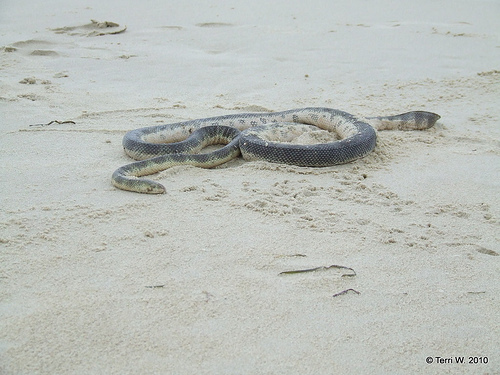

In [9]:
from IPython.display import Image
Image("/Users/fmcquillan/Documents/Product/MADlib/Demos/data/ImageNet/ILSVRC2012_img_val/ILSVRC2012_val_00000001.JPEG")

In [12]:
label [0]

[(u'n01751748', u'sea_snake', 0.5346089),
 (u'n01737021', u'water_snake', 0.1408455),
 (u'n01697457', u'African_crocodile', 0.05819438),
 (u'n01744401', u'rock_python', 0.055647947),
 (u'n01755581', u'diamondback', 0.041236367)]

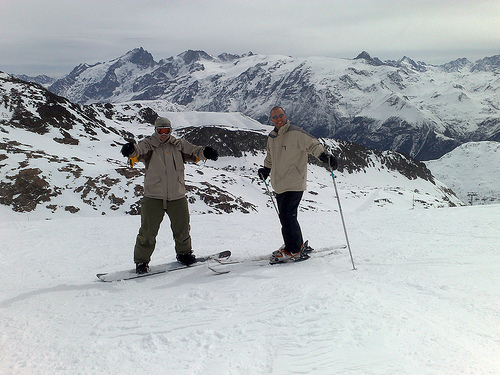

In [49]:
Image("/Users/fmcquillan/Documents/Product/MADlib/Demos/data/ImageNet/ILSVRC2012_img_val/ILSVRC2012_val_00000002.JPEG")

In [13]:
label[1]

[(u'n04228054', u'ski', 0.6965568),
 (u'n09193705', u'alp', 0.29820144),
 (u'n04208210', u'shovel', 0.0016679094),
 (u'n03792972', u'mountain_tent', 0.0007202051),
 (u'n03218198', u'dogsled', 0.00038468122)]

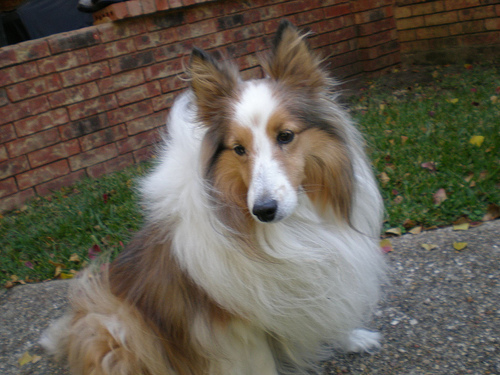

In [51]:
Image("/Users/fmcquillan/Documents/Product/MADlib/Demos/data/ImageNet/ILSVRC2012_img_val/ILSVRC2012_val_00000003.JPEG")

In [14]:
label[2]

[(u'n02106030', u'collie', 0.5772368),
 (u'n02105855', u'Shetland_sheepdog', 0.40733615),
 (u'n02090622', u'borzoi', 0.0075451825),
 (u'n02088094', u'Afghan_hound', 0.0007474787),
 (u'n02096294', u'Australian_terrier', 0.00054024416)]

<a id="resnet50_predict"></a>
## 4b. ResNet50

In [7]:
%%sql
DROP TABLE IF EXISTS imagenet_predict_resnet50;

SELECT madlib.madlib_keras_predict_byom('model_arch_library_imagenet',  -- model arch for ImageNet
                                         2,                    -- model arch id = 2 for ResNet50
                                        'imagenet_validation_data',  -- validation data
                                        'id',                  -- id column
                                        'x',                   -- independent var
                                        'imagenet_predict_resnet50',    -- output table
                                        'response',            -- prediction type
                                         FALSE,                -- use gpus
                                         NULL,                 -- class values
                                         NULL                  -- normalizing const
                                   );
SELECT COUNT(*) FROM imagenet_predict_resnet50;

Done.
1 rows affected.
1 rows affected.


count
50000


Missclassification count:

In [10]:
%%sql
SELECT COUNT(*) FROM imagenet_predict_resnet50 JOIN imagenet_validation_data USING (id)
WHERE imagenet_predict_resnet50.estimated_dependent_var != imagenet_validation_data.y;

1 rows affected.


count
15867


Predict accuracy. From https://keras.io/applications/ top-1 accuracy claim is 0.749.  Difference in accuracy is likely due to differences in image cropping and pre-processing.

In [4]:
%%sql
SELECT round(count(*)*100.0/50000,2) as test_accuracy_percent from
    (select imagenet_validation_data.y as actual, imagenet_predict_resnet50.estimated_dependent_var as estimated
     from imagenet_predict_resnet50 inner join imagenet_validation_data
     on imagenet_validation_data.id=imagenet_predict_resnet50.id) q
WHERE q.actual=q.estimated;

1 rows affected.


test_accuracy_percent
68.27
